Available folders:
1. 20240913_144441
2. 20240913_150613
3. 20240913_151730
4. 20240913_152542


Select a folder by number (1-4):  4


Selected folder: /media/saggitarius/T7/GPS_data/20240913_152542


,timestamp,lat,lon,alt


ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

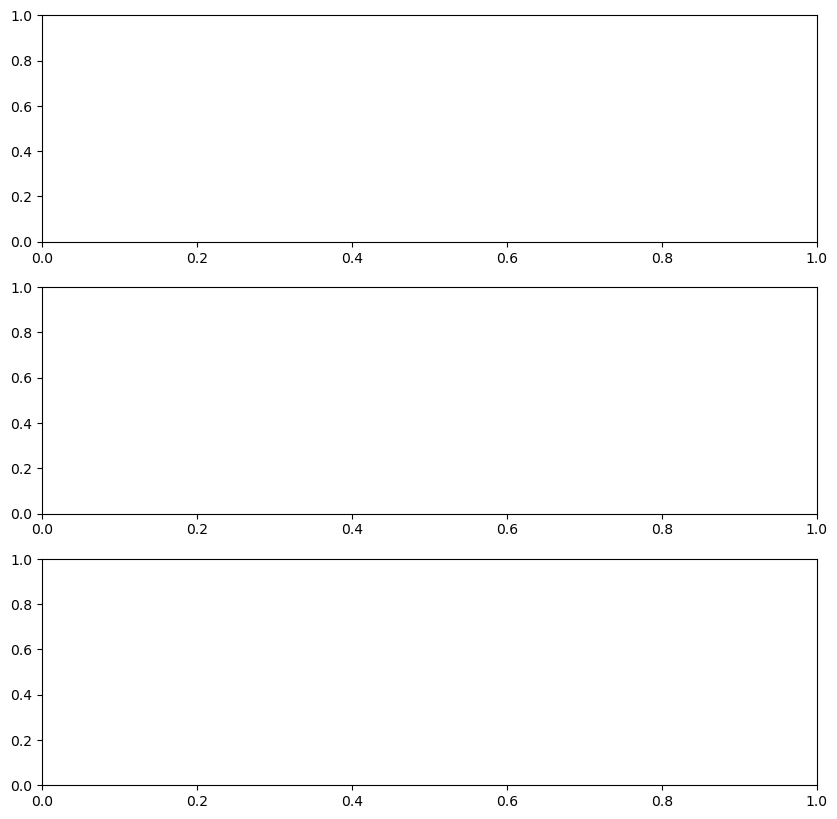

In [2]:
import matplotlib.pyplot as plt
import csv
from datetime import datetime, timedelta
import os
import numpy as np
import paramiko
import getpass
from scp import SCPClient
import tkinter as tk
from tkinter import filedialog

def parse_gpgga(line):
    parts = line.split(',')
    if len(parts) < 15 or not parts[1]:
        return None
    
    try:
        time = datetime.strptime(parts[1], '%H%M%S.%f').time()
        lat = float(parts[2][:2]) + float(parts[2][2:]) / 60
        if parts[3] == 'S':
            lat = -lat
        lon = float(parts[4][:3]) + float(parts[4][3:]) / 60
        if parts[5] == 'W':
            lon = -lon
        altitude = float(parts[9]) if parts[9] else None
        return time, lat, lon, altitude
    except ValueError:
        return None

def parse_hehdt(line):
    parts = line.split(',')
    if len(parts) < 2:
        return None
    
    try:
        heading = float(parts[1])
        return heading
    except ValueError:
        return None

def load_and_parse_file(filename):
    data = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('$GPGGA'):
                parsed = parse_gpgga(line)
                if parsed:
                    time, lat, lon, altitude = parsed
                    data.append({'time': time, 'lat': lat, 'lon': lon, 'altitude': altitude, 'heading': None})
            elif line.startswith('$HEHDT'):
                heading = parse_hehdt(line)
                if heading is not None and data:
                    data[-1]['heading'] = heading
    
    return data



def plot_data(data):
    times = [d['time'] for d in data]
    lats = [d['lat'] for d in data]
    lons = [d['lon'] for d in data]
    altitudes = [d['altitude'] for d in data]
    headings = [d['heading'] for d in data]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
    
    # Convert times to minutes since midnight for better readability
    minutes = np.array([(t.hour * 60 + t.minute + t.second / 60) for t in times])
    
    # Plot latitude over time
    ax1.plot(minutes, lats)
    ax1.set_xlabel('Time (minutes since midnight)')
    ax1.set_ylabel('Latitude')
    ax1.set_title('Latitude over Time')
    ax1.ticklabel_format(useOffset=False, style='plain')

    # Plot longitude over time
    ax2.plot(minutes, lons)
    ax2.set_xlabel('Time (minutes since midnight)')
    ax2.set_ylabel('Longitude')
    ax2.set_title('Longitude over Time')
    ax2.ticklabel_format(useOffset=False, style='plain')

    # Plot altitude over time
    if altitudes and not all(a is None for a in altitudes):
        ax3.plot(minutes, altitudes)
        ax3.set_xlabel('Time (minutes since midnight)')
        ax3.set_ylabel('Altitude (m)')
        ax3.set_title('Altitude over Time')
    else:
        ax3.text(0.5, 0.5, 'No altitude data available', ha='center', va='center')

    # Plot heading over time
    if headings and not all(h is None for h in headings):
        valid_headings = [(m, h) for m, h in zip(minutes, headings) if h is not None]
        if valid_headings:
            valid_minutes, valid_heading_values = zip(*valid_headings)
            ax4.plot(valid_minutes, valid_heading_values)
            ax4.set_xlabel('Time (minutes since midnight)')
            ax4.set_ylabel('Heading (degrees)')
            ax4.set_title('Heading over Time')
    else:
        ax4.text(0.5, 0.5, 'No heading data available', ha='center', va='center')

    plt.tight_layout()
    plt.show()

def calculate_statistics(data):
    total_distance = 0
    max_speed = 0
    altitudes = [d['altitude'] for d in data if d['altitude'] is not None]
    headings = [d['heading'] for d in data if d['heading'] is not None]

    for i in range(1, len(data)):
        prev, curr = data[i-1], data[i]
        dlat = curr['lat'] - prev['lat']
        dlon = curr['lon'] - prev['lon']
        dist = ((dlat**2 + dlon**2)**0.5) * 111.32  # Approximate conversion to km
        total_distance += dist
        
        time_diff = (datetime.combine(datetime.min, curr['time']) - datetime.combine(datetime.min, prev['time'])).total_seconds() / 3600
        speed = dist / time_diff if time_diff > 0 else 0
        max_speed = max(max_speed, speed)

    return {
        'total_distance': total_distance,
        'max_speed': max_speed,
        'max_altitude': max(altitudes) if altitudes else None,
        'min_altitude': min(altitudes) if altitudes else None,
        'avg_heading': sum(headings) / len(headings) if headings else None
    }

def connect_to_remote():
    host = input("Enter the remote host IP: ")
    username = input("Enter your username: ")
    password = getpass.getpass("Enter your password: ")

    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    try:
        ssh.connect(host, username=username, password=password)
        return ssh
    except Exception as e:
        print(f"Failed to connect: {e}")
        return None

def get_remote_folders(ssh):
    stdin, stdout, stderr = ssh.exec_command('ls -d /media/saggitarius/T7/GPS_data/*/')
    folders = stdout.read().decode().splitlines()
    return [folder.strip('/') for folder in folders]

def select_remote_folder(folders):
    print("Available GPS data folders:")
    for i, folder in enumerate(folders, 1):
        print(f"{i}. {os.path.basename(folder)}")
    
    while True:
        try:
            choice = int(input("Enter the number of the folder you want to copy (or 0 to exit): "))
            if choice == 0:
                return None
            if 1 <= choice <= len(folders):
                return folders[choice - 1]
            else:
                print("Invalid choice. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def copy_remote_folder(ssh, remote_folder, local_folder):
    scp = SCPClient(ssh.get_transport())
    try:
        scp.get(remote_folder, local_folder, recursive=True)
        print(f"Successfully copied {remote_folder} to {local_folder}")
    except Exception as e:
        print(f"Failed to copy folder: {e}")
    finally:
        scp.close()

def select_local_folder():
    root = tk.Tk()
    root.withdraw()
    folder_path = filedialog.askdirectory(title="Select folder to save GPS data")
    return folder_path

def select_file_to_analyze(folder):
    files = [f for f in os.listdir(folder) if f.endswith('.txt')]
    
    if not files:
        print("No GPS log files found in the selected folder.")
        return None

    print("Available GPS log files:")
    for i, file in enumerate(files, 1):
        print(f"{i}. {file}")
    
    while True:
        try:
            choice = int(input("Enter the number of the file you want to analyze (or 0 to exit): "))
            if choice == 0:
                return None
            if 1 <= choice <= len(files):
                return os.path.join(folder, files[choice - 1])
            else:
                print("Invalid choice. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a number.")

def main():
    ssh = connect_to_remote()
    if not ssh:
        return

    remote_folders = get_remote_folders(ssh)
    selected_remote_folder = select_remote_folder(remote_folders)
    if not selected_remote_folder:
        ssh.close()
        return

    local_folder = select_local_folder()
    if not local_folder:
        ssh.close()
        return

    copy_remote_folder(ssh, selected_remote_folder, local_folder)
    ssh.close()

    input_file = select_file_to_analyze(local_folder)
    if not input_file:
        print("No file selected. Exiting.")
        return

    data = load_and_parse_file(input_file)
    if not data:
        print("No valid GPS data found in the file.")
        return

    plot_data(data)
    
    stats = calculate_statistics(data)
    print("\nStatistics:")
    print(f"Total distance traveled: {stats['total_distance']:.2f} km")
    print(f"Maximum speed: {stats['max_speed']:.2f} km/h")
    if stats['max_altitude'] is not None:
        print(f"Maximum altitude: {stats['max_altitude']:.2f} m")
    if stats['min_altitude'] is not None:
        print(f"Minimum altitude: {stats['min_altitude']:.2f} m")
    if stats['avg_heading'] is not None:
        print(f"Average heading: {stats['avg_heading']:.2f}°")
    
    print(f"\nProcessed {len(data)} data points")

if __name__ == "__main__":
    main()